In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost as xgb
# check version number
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from imblearn.under_sampling import TomekLinks
from collections import Counter
from imblearn.over_sampling import SMOTE
import shap

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [3]:
data_path = '../../Data/'

In [4]:
app_train = pd.read_csv(data_path + 'Processed/app_train_processed.csv')
bureau = pd.read_csv(data_path + 'Processed/bureau_data.csv')

In [5]:
app_test = pd.read_csv(data_path + 'Processed/app_test_processed.csv')
X_test1 = app_test.merge(bureau, on = 'SK_ID_CURR', how = 'left')
X_test1.fillna(0, inplace = True)
ids = X_test1['SK_ID_CURR']
X_test1.drop(columns = ['SK_ID_CURR','Unnamed: 0'], inplace = True )

In [6]:
data = app_train.merge(bureau, on = 'SK_ID_CURR', how = 'left')
data.fillna(0, inplace = True)

In [7]:
data.drop(columns = 'SK_ID_CURR', inplace = True )

In [8]:
y = data['TARGET']
col = list(data.columns)
col.remove('TARGET')
X = data[col]
X.drop(columns = ['CODE_GENDER_XNA','NAME_INCOME_TYPE_Maternity leave','NAME_FAMILY_STATUS_Unknown','Unnamed: 0'], inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

   ### Model
    

In [ ]:
def run_cv(X, y):
    clf = LogisticRegression(random_state=0)
    parameters = {'penalty':('l1', 'L2','none'), 'C':[0.5, 1, 2, 5], 'max_iter' : [300]}
    cv = GridSearchCV(clf, parameters, cv = 10)
    cv.fit(X, y)
    return cv.best_params_

In [ ]:
def run_model(X, y, **params):
    
    model = LogisticRegression(**params)
    
    model.fit(X, y)
    
    return model
    

In [10]:
def run_xgb_model(X, y, **params):
    
    model = xgb.XGBClassifier(**params)
    
    model.fit(X, y)
    
    return model
    

### Undersampling

In [ ]:
undersample = NearMiss(version=1)
X, y = undersample.fit_resample(X_train, y_train)

params = run_cv(X, y)



In [ ]:
model = run_model(X, y, **params)

y_pred = model.predict(X_train)
confusion_matrix(y_pred, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
confusion_matrix(y_pred, y_test)

### OverSampling

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
X, y = oversample.fit_resample(X_train, y_train)
params = run_cv(X, y)
model = run_model(X, y, **params)
y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)

In [ ]:
model = run_model(X, y, **params)
y_pred = model.predict(X_train)
confusion_matrix(y_pred, y_train)

### Clustering and Resampling

In [ ]:
class1 = pd.concat([X_train, y_train] , axis = 1)

In [ ]:
length = len(class1[class1.TARGET == 1])
data = class1[class1.TARGET == 0]
dcols = list(data.columns)
dcols.remove('TARGET')
data = data[dcols]

In [ ]:
data.shape

In [ ]:
inertia = []
for n in range(2, 10):
    kmedoids = KMedoids(n_clusters=2, random_state=0).fit(data)
    inertia.append(kmedoids.inertia_)

In [ ]:
inertia = []
for n in range(2, 20):
    KMean = KMeans(n_clusters=n, random_state=0).fit(data)
    inertia.append(KMean.inertia_)

In [ ]:
plt.plot(inertia)

In [ ]:
KMean = KMeans(n_clusters=7, random_state=0).fit(data)
total = length // 7

cluster = KMean.predict(data)




In [ ]:
cluster_data = pd.DataFrame(cluster, columns = ['cluster'])
data_out = pd.concat([data, cluster_data], axis = 1)
data_out = data_out[~data_out.NAME_CONTRACT_TYPE.isnull()]

In [ ]:
df1 = data_out[data_out.cluster != 0]
df2 = data_out[data_out.cluster == 0].head(10000)

In [ ]:
df = pd.concat([df1,df2])

In [ ]:
df.drop(columns = 'cluster', inplace = True)

In [ ]:
df['TARGET'] = 0

In [ ]:
final_data = pd.concat([df, class1[class1.TARGET == 1]])

In [ ]:
cols = list(final_data.columns)
cols.remove('TARGET')
X =  final_data[cols]
y = final_data['TARGET']

In [ ]:
model = run_model(X, y, **params)
y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)

### Weights

In [ ]:
params = run_cv(X, y)
params['class_weight'] = {0:1, 1:10}
model = run_model(X, y, **params)
y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)
classification_report(y_pred, y_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
classification_report(y_pred, y_test)

In [ ]:
y_pred = model.predict_proba(X_test1)

In [ ]:
y_pred1  = y_pred[:,1]
submission = pd.concat([ids, pd.Series(y_pred1)], axis = 1)
submission.columns = ['SK_ID_CURR', 'TARGET']
submission.to_csv('submission.csv')

In [ ]:
submission = pd.concat([ids, pd.Series(y_pred1)], axis = 1)

In [ ]:
submission.columns = ['SK_ID_CURR', 'TARGET']

In [ ]:
submission.count(0)

In [ ]:
submission.to_csv('submission.csv')

In [ ]:
cols = [ i for i in list(X.columns) if i not in list(X_test1.columns)]

### Tomek Links & SMOTE

In [ ]:
tl = TomekLinks( )
X_tl, y_tl,  = tl.fit_sample(X_train, y_train)

In [ ]:
Counter(y_train)

In [ ]:
Counter(y_tl)

In [ ]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_tl, y_tl)

In [ ]:
Counter(y_train)

In [ ]:

params = run_cv(X_train, y_train)
model = run_model(X_train, y_train, **params)
params['class_weight'] = {0:3, 1:4}
y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)

In [11]:

params = {'max_depth' : 6, 'n_estimators' :  700, 'gamma' : 2, 'subsample': 0.7, 'scale_pos_weight': 10 }
model = run_xgb_model(X_train, y_train, **params)


In [12]:
y_pred = model.predict(X_train)
print(confusion_matrix(y_pred, y_train))

y_pred = model.predict(X_test)
print(confusion_matrix(y_pred, y_test))

[[196314    299]
 [ 15685  18335]]
[[62415  3930]
 [ 8272  2261]]


In [ ]:
#model.get_score(importance_type='weight')
model.booster().get_score(importance_type='weight')

In [ ]:
xgb.plot_importance(model, 10)

In [ ]:
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(10, importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [13]:
rf_shap_values = shap.TreeExplainer(model).shap_values(X_train)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

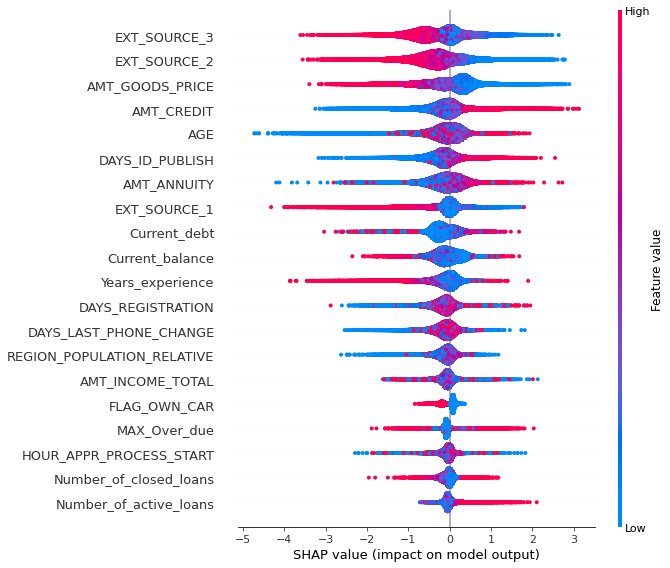

In [18]:
shap.summary_plot(rf_shap_values, X_train)

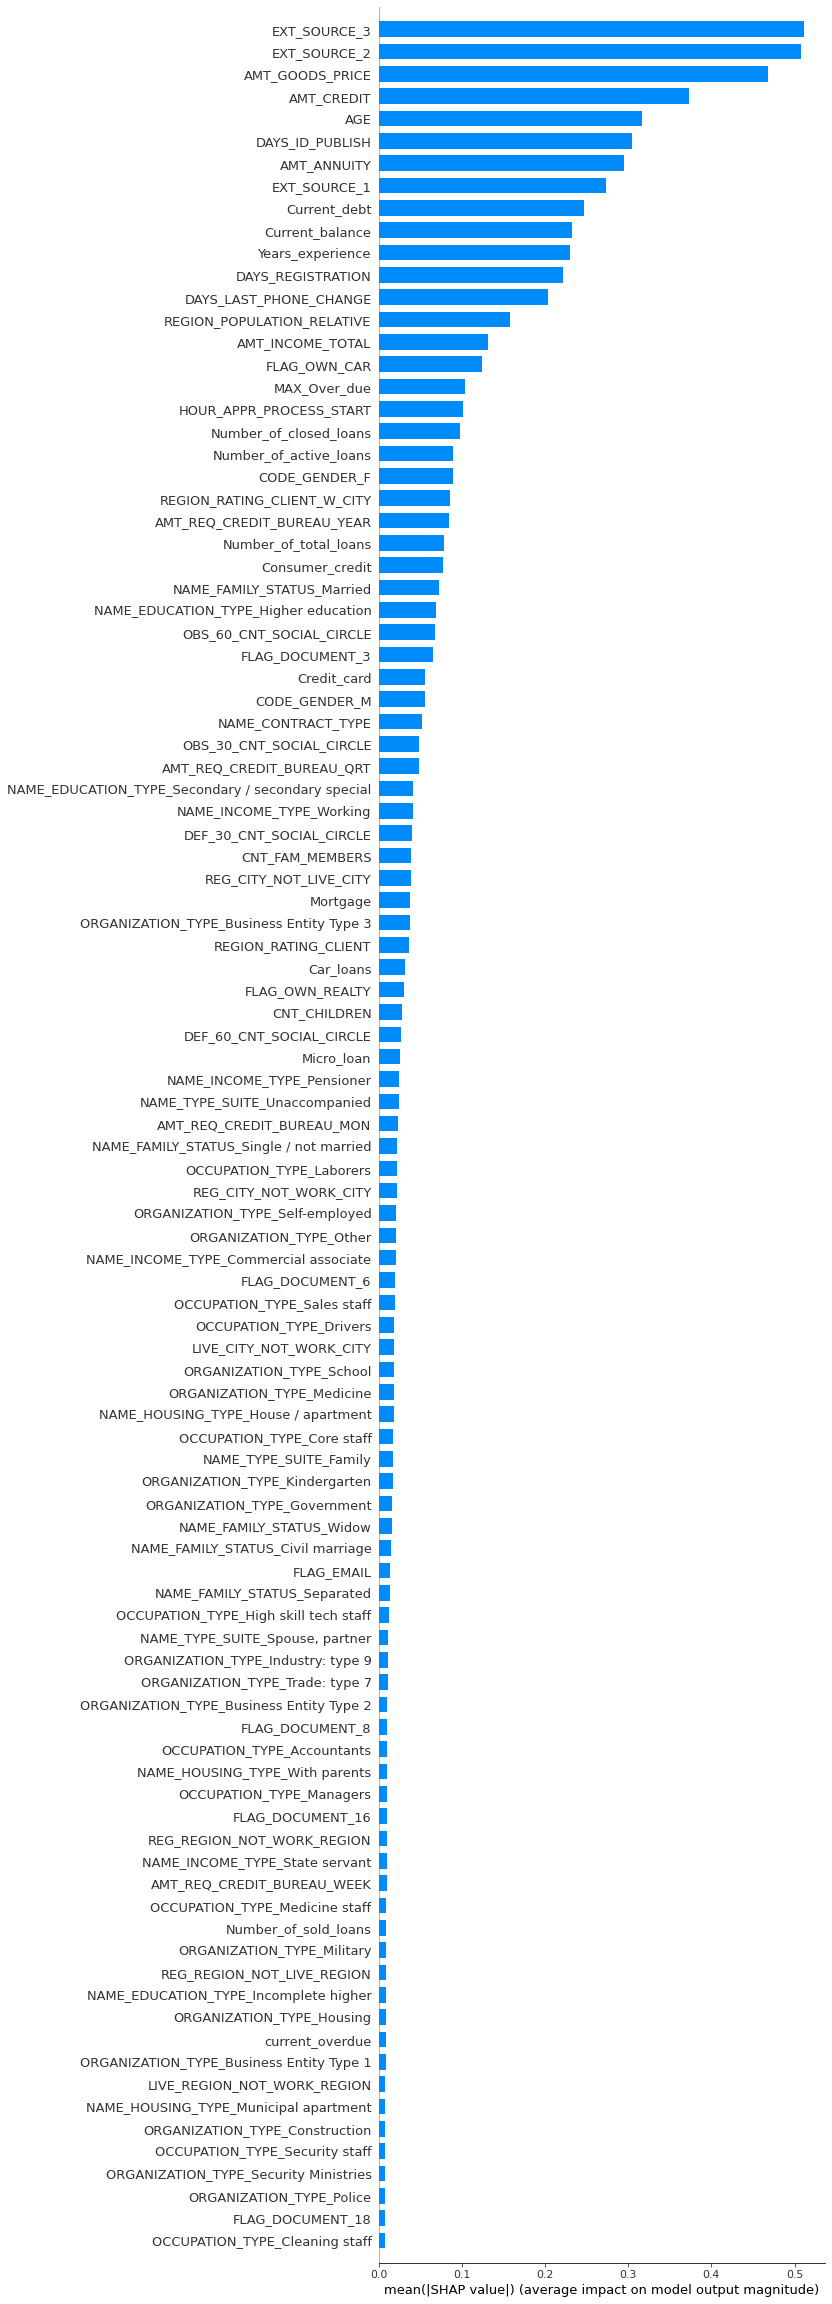

In [15]:
shap.summary_plot(rf_shap_values, X_train, plot_type = 'bar', max_display = 100)

In [ ]:
shap.summary_plot(rf_shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [16]:
app_train.shape

(307511, 164)

### Over full Data

In [ ]:
tl = TomekLinks( )
X_tl_full, y_tl_full  = tl.fit_sample(X, y)
oversample = SMOTE()
X_train1, y_train1 = oversample.fit_resample(X_tl_full, y_tl_full)

params = run_cv(X_train1, y_train1)
model = run_model(X_train1, y_train1, **params)
params['class_weight'] = {0:3, 1:4}
y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)

In [ ]:
y_out = model.predict_proba(X_test1)

In [ ]:
y_out

In [ ]:
y_pred1  = y_out[:,1]
submission = pd.concat([ids, pd.Series(y_pred1)], axis = 1)
submission.columns = ['SK_ID_CURR', 'TARGET']
submission.to_csv('submission_2.csv')